# Описание проекта 

Такси компания собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Для этого необходимо построить модель с такими предсказаниями

## Описание данных 

Компания предоставила датасет `taxi.csv`, в котором количество заказов находится в столбце `num_orders`. 

Датасет `taxi.csv` является временным рядом. 

# Выгрузка и ознакомление с данными 

In [1]:
# Необходимые импорты
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

# Преобразование и обработка данных
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import (train_test_split, 
                                     TimeSeriesSplit, 
                                    GridSearchCV)
from sklearn.preprocessing import (StandardScaler, 
                                   MinMaxScaler, 
                                  OneHotEncoder)
from sklearn.impute import SimpleImputer
from sklearn.metrics import root_mean_squared_error

# Импорт моделей
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor


In [2]:
df = pd.read_csv('C:/Users/79952/Desktop/Datasets/taxi.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [4]:
df.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


## Предобработка данных 

In [5]:
# Изменение типов данных
df['datetime'] = pd.to_datetime(df['datetime'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


Типы данных успешно изменены

## Ресемплирование 

Теперь после приведения к правильному типу, проведем ресемплирование данных

In [6]:
df = df.resample('1H', on='datetime').sum()

In [7]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


Пропусков в датасете не наблюдается. Проверка на дубликаты не требуется, так как в датасете остался один столбец с целочисленными значениями. Очевидно, что таких дублей будет довольно много, но избавляться от них не надо

# Исследовательский анализ 

## Анализ распределения 

In [9]:
# Функция для исследовательского анализа количественных признаков

def EDA_numeric(feature, bins=30, kde=True):
    
    print('Описательная статистика: ' + feature)
    display(df[feature].describe())
    
    sns.histplot(data=df, x=feature, bins=bins, kde=kde)
    plt.title('Гистограмма признака: ' + feature)
    plt.xlabel(feature)
    plt.ylabel('Частота')
    plt.show()

    sns.boxplot(data=df, y=feature)
    plt.title('Боксплот признака: ' + feature)
    plt.show()

Описательная статистика: num_orders


count    4416.000000
mean       84.422781
std        45.023853
min         0.000000
25%        54.000000
50%        78.000000
75%       107.000000
max       462.000000
Name: num_orders, dtype: float64

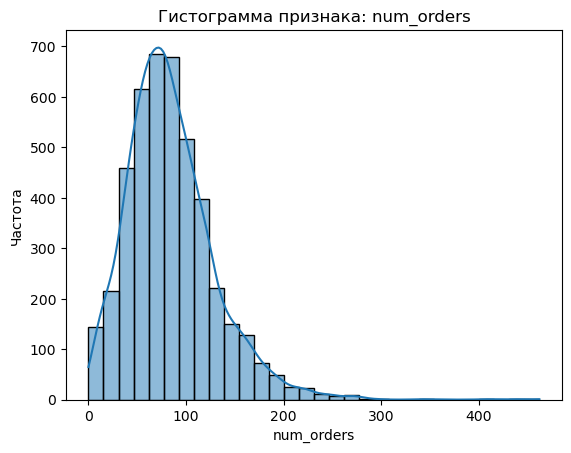

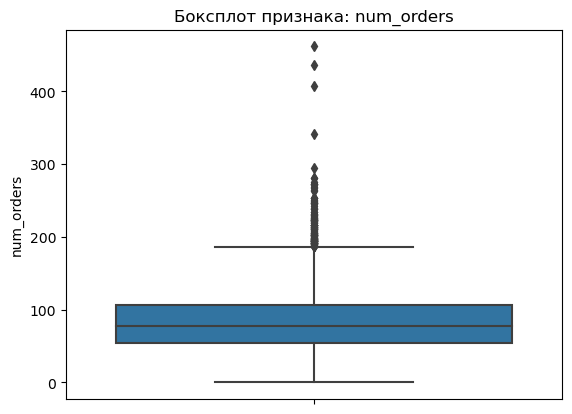

In [10]:
EDA_numeric('num_orders')

Аномальных значений не наблюдается

## Анализ трендов и сезонности 

Для начала взглянем на график наших данных вместе с скользящим средним

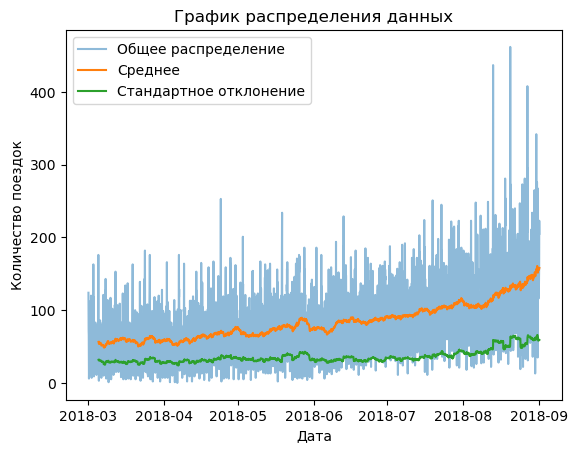

In [11]:
plt.subplot(111)
plt.plot(df, alpha=0.5)
plt.plot(df.rolling(100).mean())
plt.plot(df.rolling(100).std())
plt.legend(['Общее распределение', 'Среднее', 'Стандартное отклонение'])
plt.title('График распределения данных')
plt.xlabel('Дата')
plt.ylabel('Количество поездок')
plt.show()

**Вывод**: временной ряд является нестационарным, так как наблюдается явное увеличение среднего и стандартного отклонения с течением времени. Количество поездок с марта по август (включительно) увеличивается

Проведем анализ трендов, сезонности и шумов в наших данных за разные промежутки времени 

Нам даны данные за 6 месяцев. Для начала построим графики за 2 дня

In [12]:
df_day = df['2018-03-02':'2018-03-03']
df_day = seasonal_decompose(df_day)

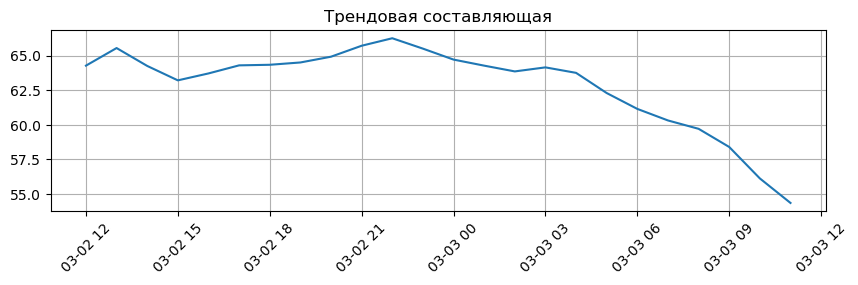

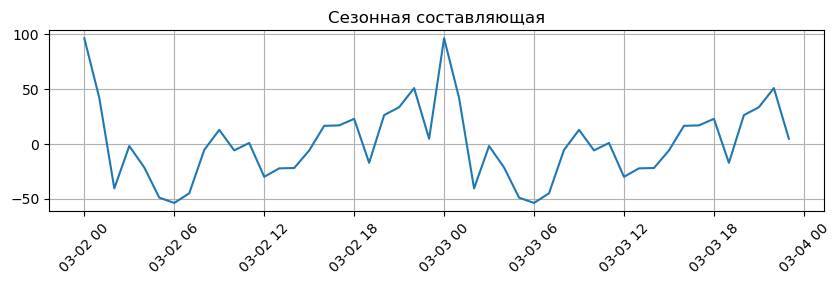

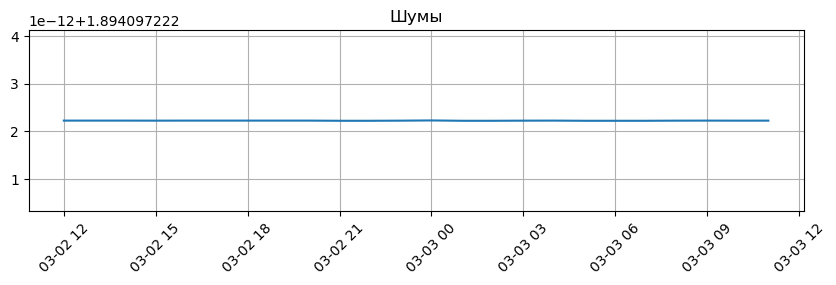

In [13]:
def trend_analysis(period): 
    '''Функция выводит графики составляющих определенного периода'''
    plt.figure(figsize=(10, 8))
    plt.subplot(311)
    plt.plot(period.trend)
    plt.xticks(rotation=45)
    plt.grid()
    plt.title('Трендовая составляющая')
    plt.show()
    
    plt.figure(figsize=(10, 8))
    plt.subplot(312)
    plt.plot(period.seasonal)
    plt.xticks(rotation=45)
    plt.grid()
    plt.title('Сезонная составляющая')
    plt.show()

    plt.figure(figsize=(10, 8))
    plt.subplot(313)
    plt.plot(period.resid)
    plt.xticks(rotation=45)
    plt.grid()
    plt.title('Шумы')
    plt.show()
    
trend_analysis(df_day)

Период исследования слишком мал. Необходимо увеличить диапазон времени

Теперь возьмем 10 дней

In [14]:
df_10days = df['2018-03-02':'2018-03-12']
df_10days = seasonal_decompose(df_10days)

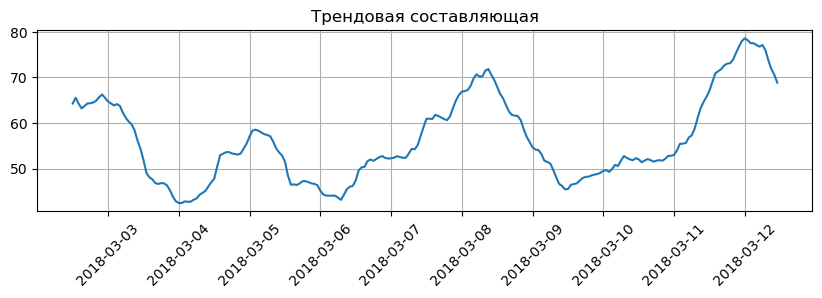

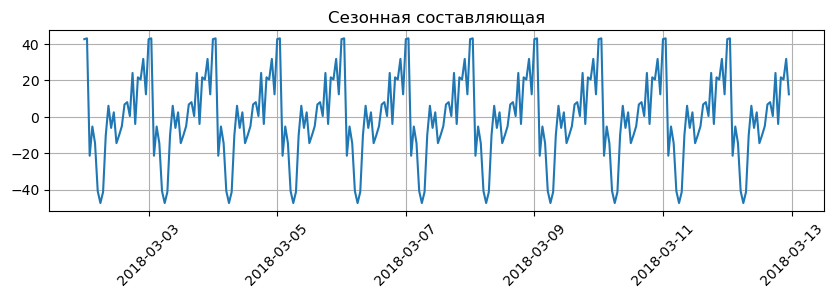

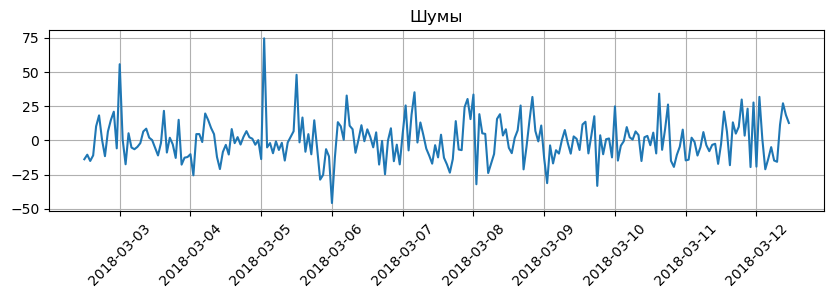

In [15]:
trend_analysis(df_10days)

Ресемплируем ряд по дню и посмотрим на распределение составляющих

In [16]:
df_second_resample = df.resample('1d').sum()

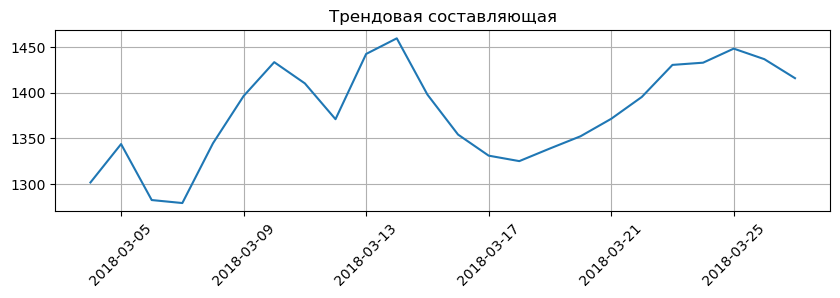

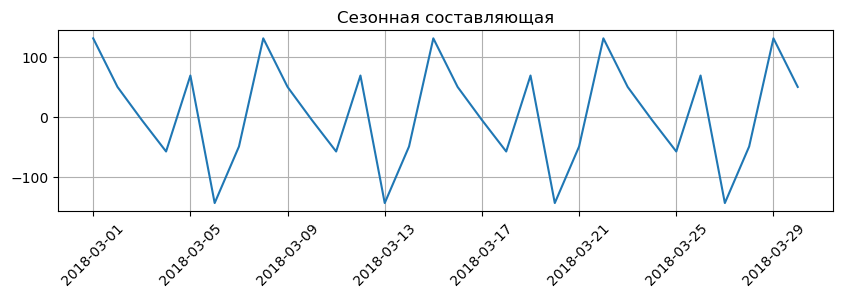

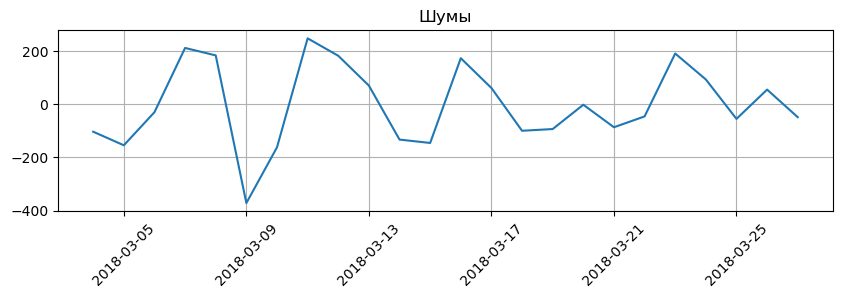

In [17]:
df_month = df_second_resample['2018-03-01':'2018-03-30']
df_month = seasonal_decompose(df_month)
trend_analysis(df_month)

# Корреляционный анализ 

Проведем автокорреляцию и определим значимые сдвиги.

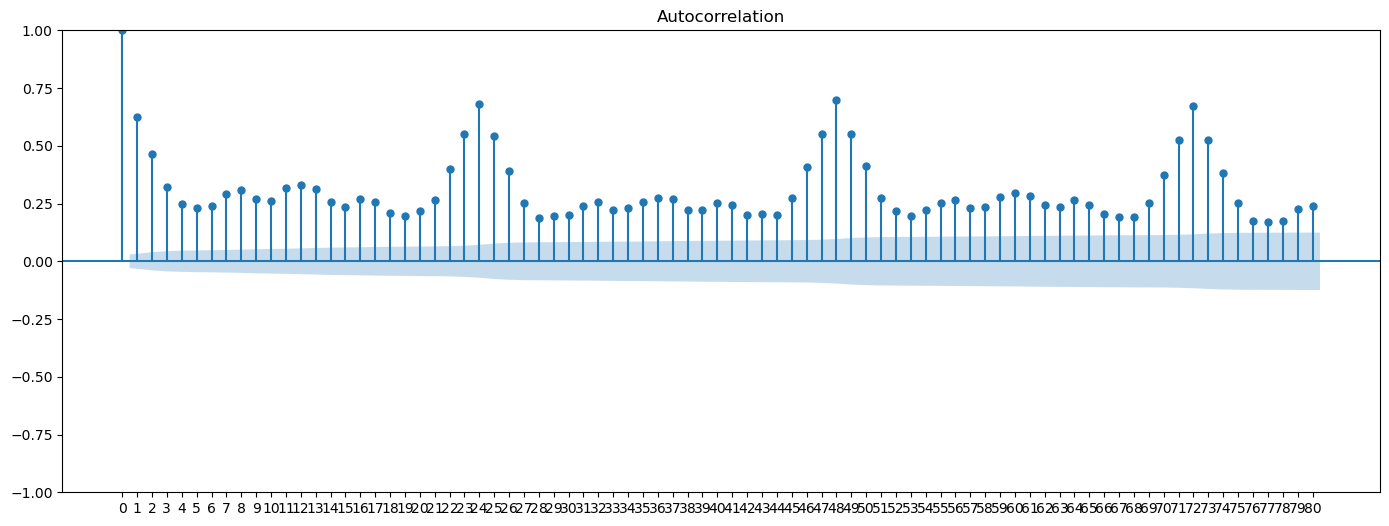

In [18]:
fig, ax = plt.subplots(figsize=(17, 6))
plot_acf(df, lags=80, ax=ax)
plt.xticks(range(0, 81, 1)) 
plt.show()

Как видно, данные повторяются каждый раз со сдвигом примерно 25. 

# Добавление признаков

Необходимо создать признаки для горизонта прогнозирования в один шаг (1 час).
Добавим следующие параметры:
1. День недели поездки
2. Час поездки
3. Сдвиг на один час вперед
4. Скользящее среднее

In [19]:
# календарные признаки
# df['month'] = df.index.month
df['day_of_week'] = df.index.dayofweek
df['hour'] = df.index.hour

In [20]:
df.head()

,num_orders,day_of_week,hour
datetime,,,
2018-03-01 00:00:00,124,3,0
2018-03-01 01:00:00,85,3,1
2018-03-01 02:00:00,71,3,2
2018-03-01 03:00:00,66,3,3
2018-03-01 04:00:00,43,3,4


Календарные признаки успешно добавлены

In [21]:
# отстающие значения
df['lag_1H'] = df['num_orders'].shift(1, fill_value=0)

In [22]:
df.head()

,num_orders,day_of_week,hour,lag_1H
datetime,,,,
2018-03-01 00:00:00,124,3,0,0
2018-03-01 01:00:00,85,3,1,124
2018-03-01 02:00:00,71,3,2,85
2018-03-01 03:00:00,66,3,3,71
2018-03-01 04:00:00,43,3,4,66


Отстающие признаки успешно добавлены

In [23]:
df['rolling_mean'] = df['num_orders'].shift(1).rolling(5).mean()

In [24]:
df = df.dropna()
df.head()

,num_orders,day_of_week,hour,lag_1H,rolling_mean
datetime,,,,,
2018-03-01 05:00:00,6,3,5,43,77.8
2018-03-01 06:00:00,12,3,6,6,54.2
2018-03-01 07:00:00,15,3,7,12,39.6
2018-03-01 08:00:00,34,3,8,15,28.4
2018-03-01 09:00:00,69,3,9,34,22.0


Скользящее среднее добавлено

# Разбиение на выборки 

Для начала нужно определится с целевым признаком. Так как цель нашего прогнозирования - предсказание количества заказов на следующий час, то целевым признаком является отстающее значение `lag_1H`

In [25]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)

In [26]:
target = 'num_orders'

X_train = train.drop(columns=target)
y_train = train[target]
X_test = test.drop(columns=target)
y_test = test[target]

Тренировочные и тестовые выборки успешно получены, можно приступать к обучению

# Обучение моделей 

В качестве обучения возьмем несколько моделей с различными гиперпараметрами: 
- Ридж-регрессия
- Регрессия ближайщих соседей
- Регрессия дерева решений

Также используем следующие кодировщики: 
- Для количественных переменных: `StandardScaler` и `MinMaxScaler`
- Для категориальных: `OneHotEncoder` 

Получим наилучшую выборку при помощи кросс валидации `GridSearchCV`

In [27]:
X_train.head()

,day_of_week,hour,lag_1H,rolling_mean
datetime,,,,
2018-03-01 05:00:00,3,5,43,77.8
2018-03-01 06:00:00,3,6,6,54.2
2018-03-01 07:00:00,3,7,12,39.6
2018-03-01 08:00:00,3,8,15,28.4
2018-03-01 09:00:00,3,9,34,22.0


In [28]:
numerical_cols = ['lag_1H', 
                 'rolling_mean']

cat_cols = ['day_of_week', 
           'hour']

In [29]:
RANDOM_STATE = 1

In [30]:
# Пайплайн OHE
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
    )

# обработка данных
data_preprocessor = ColumnTransformer([
    ('ohe', ohe_pipe, cat_cols),
    ('num', StandardScaler(), numerical_cols)
], 
    remainder='passthrough')
    # force_int_remainder_cols=False)

In [31]:
# Финальный пайплайн
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor), 
    ('models', Ridge(random_state=RANDOM_STATE))
])

In [32]:
# подбор моделей и гиперпараметров
param_grid = [
    {
        'models': [Ridge(random_state=RANDOM_STATE)],
        'models__alpha': np.arange(0.1, 2, 0.3), 
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), "passthrough"]
    },  
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), "passthrough"]
    }, 
    {
        'models': [KNeighborsRegressor()], 
        'models__n_neighbors': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), "passthrough"]
    }
]

In [33]:
# Кросс валидация
tscv = TimeSeriesSplit(n_splits=3)
grid = GridSearchCV(estimator=pipe_final, 
                       cv=tscv,
                       scoring = 'neg_root_mean_squared_error',
                       param_grid=param_grid)

In [34]:
# Обучение
grid.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('simpleImputer_ohe',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False))]),...
                                                MinMaxScaler(),
                                                'passthrough']},
                         {'models': [DecisionTreeRegressor(random_state=1)],
                          'models__max_depth': range(2, 10),
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']},
                         {'models': [KNeighborsRegressor()],
                          'models__n_neighbors': range(2, 10),
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']}],
             scoring='neg_root_mean_squared_error')

In [35]:
print('Лучшая модель и ее гиперпараметры:')
print(grid.best_estimator_)

Лучшая модель и ее гиперпараметры:
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['day_of_week', 'hour']),
                                                 ('num', 'passthrough',
                                                  ['lag_1H',
                            

In [36]:
print(f'Наилучшая метрика: {(grid.best_score_) * -1}')

Наилучшая метрика: 27.82235012256883


Лучшая модель найдена, проверим ее качество на тестовой выборке

In [37]:
y_pred = grid.best_estimator_.predict(X_test)
RMSE = root_mean_squared_error(y_test, y_pred)
print(f'RMSE на тестовой выборке: {RMSE}')

RMSE на тестовой выборке: 46.601620686990564


Метрика RMSE в пределах нормы.

# Общий вывод 

В ходе данной работы были выполнены следующие пункты: 
- Выгрузка и ознакомление с данными 
- Предобработка и ресемплинг данных
- Ислледовательский анализ: исследовано распределение значений, а также тренды и сезонность
- Добавлены необходимые признаки для обучения моделей
- Выполнено разбиение на выборки 
- Обучены несколько моделей с различными гиперпараметрами и кодировщиками при помощи кросс-валидации

В результате чего наилучшей моделью оказалась Ридж-регрессия со следующими гиперпараметрами

In [38]:
print(grid.best_estimator_)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['day_of_week', 'hour']),
                                                 ('num', 'passthrough',
                                                  ['lag_1H',
                                                   'rolling_mea

In [39]:
print(f'Метрика RMSE на тестовой выборке показала результат {RMSE}')

Метрика RMSE на тестовой выборке показала результат 46.601620686990564


Заказчику рекомендуется использовать данную модель с показанными выше кодировщиками и гиперпараметрами. 